# Experiment 2
Adjust the size of dataset (valid set) to see what happens to the performance of various calibration models

In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [6]:
import importlib
from pprint import pprint
import numpy as np
import pandas as pd
from typing import Iterable

In [20]:
from probcalkge import Experiment, DatasetWrapper, ExperimentResult
from probcalkge import get_datasets, get_calibrators, get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error

In [4]:
ds = get_datasets()
cals = get_calibrators()
kges = get_kgemodels()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [7]:
def dataset_stats(ds: Iterable[DatasetWrapper]) -> pd.DataFrame:
    vals = []
    rows = []
    cols = ['train', 'valid', 'test']
    for i in ds:
        rows.append(i.name)
        vals.append(i.stats)
    return pd.DataFrame(vals, index=rows, columns=cols)

In [8]:
df = dataset_stats(ds)
df

,train,valid,test
FB13k,316232,11816,47464
WN11,110361,4877,19706
YAGO39,354994,18474,18514
DBpedia50,32388,246,4196
UMLS,5216,1304,1322
Kinship,8544,2136,2148
Nations,1592,398,402


In [53]:
import random
from probcalkge import DatasetWrapper

def shrink_dataset(ds: DatasetWrapper, perc=0.5) -> DatasetWrapper:
    '''
    Shrink the size of dataset training samples by randon sampling
    '''
    new_X_train = random.sample(ds.X_train.tolist(), int(perc * len(ds.X_train)))
    new_X_train = np.array(new_X_train)
    new_X_ents = set(new_X_train[:, 0]).union(set(new_X_train[:, 2]))
    new_X_rels = set(new_X_train[:, 1])

    new_X_valid, new_y_valid = [], []
    for X, y in zip(ds.X_valid, ds.y_valid):
        if X[0] in new_X_ents and X[2] in new_X_ents and X[1] in new_X_rels:
            new_X_valid.append(X.tolist())
            new_y_valid.append(y)
    new_X_valid, new_y_valid = np.array(new_X_valid), np.array(new_y_valid)
    
    new_X_test, new_y_test = [], []
    for X, y in zip(ds.X_test, ds.y_test):
        if X[0] in new_X_ents and X[2] in new_X_ents and X[1] in new_X_rels:
            new_X_test.append(X.tolist())
            new_y_test.append(y)
    new_X_test, new_y_test = np.array(new_X_test), np.array(new_y_test)

    return DatasetWrapper(f'{ds.name}',
                            new_X_train,
                            new_X_valid, new_y_valid,
                            new_X_test, new_y_test
    )

def shrink_valid(ds: DatasetWrapper, perc=0.5) -> DatasetWrapper:
    valids = np.hstack([ds.X_valid, ds.y_valid.reshape([-1, 1])])
    new_valids = np.array(random.sample(valids.tolist(), int(perc * len(valids))))
    return DatasetWrapper(f'{ds.name}',
                            ds.X_train,
                            new_valids[:, :3], new_valids[:, 3].astype(int),
                            ds.X_test, ds.y_test
    )


In [55]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.histbin, cals.beta], 
    datasets=[ds.fb13, ds.wn18, ds.yago39], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[brier_score, negative_log_loss, ks_error]
)

exp.load_trained_kges('../saved_models/')

exp_reses = []

for i in (1.0, 0.7, 0.4, 0.1, 0.05):
    new_fb = shrink_valid(ds.fb13, perc=i)
    new_wn = shrink_valid(ds.wn18, perc=i)
    new_yg = shrink_valid(ds.yago39, perc=i) 
    
    exp.datasets = [new_fb, new_wn, new_yg]
    
    exp_res = exp.run_with_trained_kges()
    # exp_res = exp.run()
    # exp.save_trained_kges(f'../saved_models/shrink-{i}/')
    exp_reses.append(exp_res)
    # newdf = exp_res.to_frame().pivot_table(values='ExpRes', index=['dataset', 'kge', 'metric'], columns=['cal'])



Loaded models:
{'DBpedia50': OrderedDict([('ComplEx',
                            <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001E6B884AC08>),
                           ('DistMult',
                            <ampligraph.latent_features.models.DistMult.DistMult object at 0x000001E6A6FAB488>),
                           ('HolE',
                            <ampligraph.latent_features.models.HolE.HolE object at 0x000001E6A6DD7B08>),
                           ('TransE',
                            <ampligraph.latent_features.models.TransE.TransE object at 0x000001E6E5ABD7C8>)]),
 'FB13k': {'ComplEx': <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001E6E98D3FC8>,
           'DistMult': <ampligraph.latent_features.models.DistMult.DistMult object at 0x000001E701C2FF48>,
           'HolE': <ampligraph.latent_features.models.HolE.HolE object at 0x000001E6A6FABF88>,
           'TransE': <ampligraph.latent_features.models.TransE.TransE object at 0x0000

In [27]:
def res_pivot(exp_res: ExperimentResult) -> pd.DataFrame:
    newdf = exp_res.to_frame().pivot_table(values='ExpRes', index=['dataset', 'kge', 'metric'], columns=['cal'])
    newdf['avg_excl_uncal'] = newdf.loc[:, newdf.columns != 'UncalCalibrator'].mean(axis=1)
    return newdf

In [64]:
lst_counts = []
for res in exp_reses:
    counts = res_pivot(res).idxmin(axis=1).value_counts()
    lst_counts.append(counts)
various_counts = pd.DataFrame(lst_counts,  columns=counts.index, index=('1.0', '0.7', '0.4', '0.1', '0.05'))
various_counts

,IsotonicCalibrator,BetaCalibrator,HistogramBinningCalibrator,PlattCalibrator
1.0,28.0,1.0,7.0,NaN
0.7,29.0,NaN,7.0,NaN
0.4,29.0,2.0,5.0,NaN
0.1,16.0,10.0,10.0,NaN
0.05,16.0,11.0,7.0,2.0


[Text(0.5, 0, 'scale'), Text(0, 0.5, 'winning counts')]

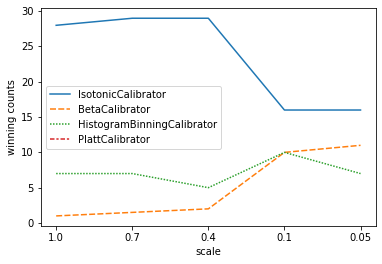

In [65]:
import seaborn as sns
ax = sns.lineplot(data=various_counts, sort=False)
ax.set(xlabel='scale', ylabel='winning counts')